tapthermal.deck_det0_copy.m
4007
(2000,)
tapfast.deck_det0_copy.m
4007
(2000,)


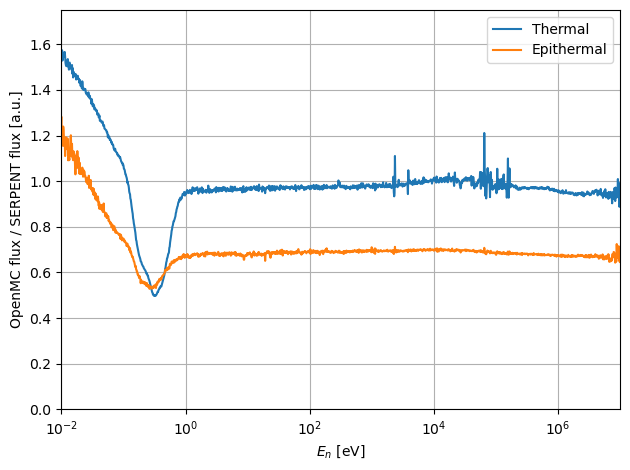

In [7]:
import openmc
import matplotlib.pyplot as plt
import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, nuclear_data_tools, model_tools
from getDetector import getDetector
import numpy as np

results_idx = {
    model_tools.THERMAL_REACTOR: 1,
    model_tools.SEMIEPITHERMAL_REACTOR: 3,
    model_tools.EPITHERMAL_REACTOR: 2,
}

# The "tapfast.deck_det0 copy.m" and "tapthermal.deck_det0 copy.m" files when using the same energy spectrum as the OpenMC model

# filename='tapfast.deck_det0 copy.m'
# fluxFast,_,_,ehigh=getDetector(filename,'fluxspect')

# filename='tapthermal.deck_det0 copy.m'
# fluxThermal,_,_,_=getDetector(filename,'fluxspect')

colors = ["tab:blue", "tab:orange", "tab:green"]

plt.figure(1)

folder_filename = lambda run_id: f"../../results/RUNDATA_R18_{run_id}"

for REACTOR_MODEL, i in results_idx.items():
    # The "tapfast.deck_det0 copy.m" and "tapthermal.deck_det0 copy.m" files when using the same energy spectrum as the OpenMC model

    if REACTOR_MODEL == model_tools.THERMAL_REACTOR:
        filename='tapthermal.deck_det0_copy.m'
    elif REACTOR_MODEL == model_tools.EPITHERMAL_REACTOR:
        filename='tapfast.deck_det0_copy.m'
    elif REACTOR_MODEL == model_tools.SEMIEPITHERMAL_REACTOR:
        continue

    fluxSERPENT,_,elowSERPENT,ehighSERPENT=getDetector(filename,'fluxspect', gs=1999)
    print(fluxSERPENT.shape)
    elowSERPENT = elowSERPENT * 1e6 # to get in eV
    ehighSERPENT = ehighSERPENT * 1e6 # to get in eV
    eSERPENT = (elowSERPENT+ehighSERPENT)/2

    run_settings = run_tools.load_run_settings_json(folder_filename(i))
    color = colors[i-1]

    # Make sure reactor_model is correct
    assert run_settings["reactor_model"] == REACTOR_MODEL

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"../../results/RUNDATA_R18_{i}/statepoint.{statepoint_number}.h5")

    # print(sp.tallies)

    tallydf1=sp.tallies[3].get_pandas_dataframe()
    # print(tallydf1.head())

    tallydf1flux=tallydf1[tallydf1['score']=='flux']
    # print(tallydf1flux.head())

    energy=(tallydf1flux['energy low [eV]']+tallydf1flux['energy high [eV]'])/2
    
    # Interpolate the flux from the SERPENT spectrum to the OpenMC spectrum
    # fluxSERPENT_interp = np.interp(energy, eSERPENT, fluxSERPENT)

    plt.figure(1)
    # factor = 21205750.411731105
    # plt.loglog(energy,tallydf1flux['mean'], label=REACTOR_MODEL.capitalize(), color=color)
    # plt.loglog(energy,fluxSERPENT_interp, label=REACTOR_MODEL.capitalize()+" SERPENT", color=color, ls='--')

    # quotient = tallydf1flux['mean']/fluxSERPENT_interp
    quotient = tallydf1flux['mean']/fluxSERPENT
    plt.semilogx(energy,quotient*1e12, label=REACTOR_MODEL.capitalize(), color=color)
    

    

plt.figure(1)
plt.xlabel('$E_n$ [eV]')
plt.ylabel('OpenMC flux / SERPENT flux [a.u.]')
plt.legend()
plt.xlim(1e-2, 1e7)
plt.ylim(0, 1.75)
plt.grid()
plt.tight_layout()
plt.savefig("flux_quotient_openmc_vs_serpent.pdf")

    